In this notebook, we will be attempting to webscrap Intern.sg, a job seeking portal for students.

In [267]:
import requests
from bs4 import BeautifulSoup
import csv 
import pandas as pd 
import matplotlib.pyplot as plt 

In [268]:
url = "https://www.internsg.com/jobs/1/#isg-top"

In [269]:
response = requests.get(url)
response

<Response [200]>

In [294]:
soup = BeautifulSoup(response.content, "html.parser")

We find that the information that we want are:
Company Name, Role, Commitment Period, Location, Website and Date Posted
There are found under the "ast-col-lg-2","ast-col-lg-1" and "ast-col-lg-3" class tags.

In [271]:
csv_file = "data.csv"

with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)

print("Empty CSV file created successfully.")

Empty CSV file created successfully.


Initializing an empty CSV to store the data.

In [272]:
location_post_tag = soup.findAll("div", class_=["ast-col-lg-2","ast-col-lg-1"])
location_post_text = [x.text.strip() for x in location_post_tag][2:]

company_role_period_div = soup.findAll("div", class_=["ast-col-lg-3"])
company_role_period_text = [x.text.strip() for x in company_role_period_div][3:]

web_type_div = [div.findAll("span", class_="text-monospace") for div in company_role_period_div]
web_type_text = [x[0].text.strip() for x in web_type_div if x != []]

We will find the respective tags and strip the text to remove any unncessary spacing

In [273]:
web_type_text

['stena.com',
 'Intern/TS',
 'fosunhivecapital.com',
 'Intern/TS',
 'vipshop.com',
 'Intern/TS',
 'bshg.com',
 'Intern/TS',
 'qiorganization.com',
 'Intern/TS',
 'mercedes-benz.com',
 'Intern/TS',
 'mercedes-benz.com',
 'Intern/TS',
 'vipshop.com',
 'Intern/TS',
 'mercedes-benz.com',
 'Intern/TS',
 'bovem.co',
 'Intern/TS',
 'hegen.com',
 'Intern/TS',
 'Featured',
 'Part/Temp',
 'space.org.sg',
 'Intern/TS',
 'wildflowerstudio.sg',
 'Intern/TS',
 'techfinconsulting.org',
 'Intern/TS',
 'techfinconsulting.org',
 'Intern/TS',
 'thefunempire.com',
 'Intern/TS',
 'Featured',
 'Intern/TS',
 'thefunempire.com',
 'Intern/TS',
 'macrayan.com.sg',
 'Part/Temp',
 'poss.sg',
 'Intern/TS',
 'castlery.com',
 'Intern/TS']

We can see that current the data are stored in a organized list, with each index representing a specific type of information. Let's split them into their respective list (columns)

In [274]:
location = location_post_text[::2]
post_date = location_post_text[1::2]
company = company_role_period_text[::3]
role = company_role_period_text[1::3]
period = company_role_period_text[2::3]
web = web_type_text[::2]
job_type = web_type_text[1::2]

Now that we have all of the respective columns, we will convert them into a dataframe and save into our csv.

In [275]:
df = pd.DataFrame({'Company Name': company,
                       'Role': role,
                       'Commitment Period': period,
                      'Location': location,
                       'Job Type': job_type,
                       'Date Posted': post_date,
                       'Website': web})

df.to_csv(csv_file, index=False, header=True)

We have successfully scraped the first page of the website. Let's repeat the rest for subsequent pages.

In [276]:
for page in range(2, 121):
    url = f"https://www.internsg.com/jobs/{page}/#isg-top"
    response = requests.get(url)
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    ##Obtaining the raw data
    location_post_tag = soup.findAll("div", class_=["ast-col-lg-2","ast-col-lg-1"])
    location_post_text = [x.text.strip() for x in location_post_tag][2:]
    company_role_period_div = soup.findAll("div", class_=["ast-col-lg-3"])
    company_role_period_text = [x.text.strip() for x in company_role_period_div][3:]
    web_type_div = [div.findAll("span", class_="text-monospace") for div in company_role_period_div]
    web_type_text = [x[0].text.strip() for x in web_type_div if x != []]

    ##Converting them to their columns.
    location = location_post_text[::2]
    post_date = location_post_text[1::2]
    company = company_role_period_text[::3]
    role = company_role_period_text[1::3]
    period = company_role_period_text[2::3]
    web = web_type_text[::2]
    job_type = web_type_text[1::2]

    ##Saving data
    df = pd.DataFrame({'Company Name': company,
                       'Role': role,
                       'Commitment Period': period,
                      'Location': location,
                       'Job Type': job_type,
                       'Date Posted': post_date,
                       'Website': web})
    
    df_existing = pd.read_csv(csv_file)
    df_combined = pd.concat([df_existing, df])
    df_combined.to_csv(csv_file, index=False)

    print(f"CSV file saved successfully for page {page}.")

CSV file saved successfully for page 2.
CSV file saved successfully for page 3.
CSV file saved successfully for page 4.
CSV file saved successfully for page 5.
CSV file saved successfully for page 6.
CSV file saved successfully for page 7.
CSV file saved successfully for page 8.
CSV file saved successfully for page 9.
CSV file saved successfully for page 10.
CSV file saved successfully for page 11.
CSV file saved successfully for page 12.
CSV file saved successfully for page 13.
CSV file saved successfully for page 14.
CSV file saved successfully for page 15.
CSV file saved successfully for page 16.
CSV file saved successfully for page 17.
CSV file saved successfully for page 18.
CSV file saved successfully for page 19.
CSV file saved successfully for page 20.
CSV file saved successfully for page 21.
CSV file saved successfully for page 22.
CSV file saved successfully for page 23.
CSV file saved successfully for page 24.
CSV file saved successfully for page 25.
CSV file saved successfu

Now let us look at our data

In [277]:
intern_df = pd.read_csv('data.csv')
intern_df

,Company Name,Role,Commitment Period,Location,Job Type,Date Posted,Website
0,Stena Line Pte Ltdstena.com,HR Intern (Marine),"From Nov 2023, For At Least 6 MonthsIntern/TS","Jurong East, SG",Intern/TS,27 Jun,stena.com
1,Fosun Hive Capital Management (Singapore) Pte....,Finance and Administration Intern,"Immediate Start, For At Least 6 MonthsIntern/TS",SG,Intern/TS,27 Jun,fosunhivecapital.com
2,Vipshop Singapore Pte Ltd.vipshop.com,Data Analyst Intern,"Immediate Start, For At Least 3 MonthsIntern/TS",SG,Intern/TS,27 Jun,vipshop.com
3,BSH Home Appliances Pte Ltdbshg.com,Service Marketing Intern,"From Aug 2023, For At Least 5 MonthsIntern/TS",SG,Intern/TS,27 Jun,bshg.com
4,BHAqiorganization.com,Financial Services Summer Intern,"Flexible Start, For At Least 2 MonthsIntern/TS","Queenstown, SG",Intern/TS,27 Jun,qiorganization.com
...,...,...,...,...,...,...,...
2635,Vision Alliance Grouppruadviser.com.sg,Sales & Marketing Associate,"Immediate Start, For At Least 6 MonthsFull/Perm","Newton, SG",Full/Perm,Closed,pruadviser.com.sg
2636,Inspire Brands Asiainspirebrandsasia.com,Content Creation Intern,"Immediate Start, Flexible DurationFree/ProjPar...","Novena, SG",Free/Proj,Closed,inspirebrandsasia.com
2637,Count On Me Pte Ltdcountonme.biz,Accounts Executive - Intern,"Immediate Start, For At Least 6 MonthsFull/Per...",SG,Full/Perm,Closed,countonme.biz
2638,Elite Asiaeliteasia.co,Englishchinese / Japanese / Korean Simultaneou...,From 08 Jun 2023 - 08 Jun 2023Free/Proj,SG,Free/Proj,Closed,eliteasia.co


We see that some of the columns are not very well formatted. I will now clean up the data by removing the `website` from the `company name` and `job type` from `commitment period` Additionally, let's add an additional column to indicate WFH availability.

In [278]:
intern_df['Company Name'] = intern_df.apply(lambda row: row['Company Name'].split(row['Website'])[0], axis=1)
intern_df['Company Name'] = intern_df.apply(lambda row: row['Company Name'].split(' Pte Ltd')[0], axis=1)    
intern_df['Commitment Period'] = intern_df.apply(lambda row: row['Commitment Period'].split(row['Job Type'])[0], axis=1)
intern_df['Work From Home'] = intern_df.apply(lambda row: True if (row['Location'].find('Work from Home') != -1) else False, axis=1)
intern_df['Location'] = intern_df.apply(lambda row: row['Location'].split('Work from Home')[0], axis=1)

In [279]:
intern_df['Country'] = intern_df.apply(lambda row: row['Location'].split(',')[-1], axis=1)
intern_df['Location'] = intern_df.apply(lambda row: row['Location'].split(',')[0] if len(row['Location'].split(',')) > 1 else None, axis=1)

In [280]:
intern_df

,Company Name,Role,Commitment Period,Location,Job Type,Date Posted,Website,Work From Home,Country
0,Stena Line,HR Intern (Marine),"From Nov 2023, For At Least 6 Months",Jurong East,Intern/TS,27 Jun,stena.com,False,SG
1,Fosun Hive Capital Management (Singapore) Pte....,Finance and Administration Intern,"Immediate Start, For At Least 6 Months",None,Intern/TS,27 Jun,fosunhivecapital.com,False,SG
2,Vipshop Singapore,Data Analyst Intern,"Immediate Start, For At Least 3 Months",None,Intern/TS,27 Jun,vipshop.com,False,SG
3,BSH Home Appliances,Service Marketing Intern,"From Aug 2023, For At Least 5 Months",None,Intern/TS,27 Jun,bshg.com,False,SG
4,BHA,Financial Services Summer Intern,"Flexible Start, For At Least 2 Months",Queenstown,Intern/TS,27 Jun,qiorganization.com,False,SG
...,...,...,...,...,...,...,...,...,...
2635,Vision Alliance Group,Sales & Marketing Associate,"Immediate Start, For At Least 6 Months",Newton,Full/Perm,Closed,pruadviser.com.sg,False,SG
2636,Inspire Brands Asia,Content Creation Intern,"Immediate Start, Flexible Duration",Novena,Free/Proj,Closed,inspirebrandsasia.com,False,SG
2637,Count On Me,Accounts Executive - Intern,"Immediate Start, For At Least 6 Months",None,Full/Perm,Closed,countonme.biz,False,SG
2638,Elite Asia,Englishchinese / Japanese / Korean Simultaneou...,From 08 Jun 2023 - 08 Jun 2023,None,Free/Proj,Closed,eliteasia.co,False,SG


In [281]:
intern_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Company Name       2640 non-null   object
 1   Role               2640 non-null   object
 2   Commitment Period  2640 non-null   object
 3   Location           1981 non-null   object
 4   Job Type           2640 non-null   object
 5   Date Posted        2640 non-null   object
 6   Website            2640 non-null   object
 7   Work From Home     2640 non-null   bool  
 8   Country            2640 non-null   object
dtypes: bool(1), object(8)
memory usage: 167.7+ KB


Once we have format our data, we can now begin to explore our data

In [282]:
company_counts = intern_df.groupby('Company Name')['Company Name'].count()
top_10_counts = company_counts.sort_values(ascending=False).head(10)
top_10_counts

Company Name
Snaphunt                         147
Orfeostory                        89
Advisors Alliance Group           84
ed&c                              74
Thye Hua Kwan Moral Charities     32
Akribis Systems                   24
Robert Bosch (SEA)                23
The Fun Empire                    20
Hypotenuse AI                     20
REC Group                         16
Name: Company Name, dtype: int64

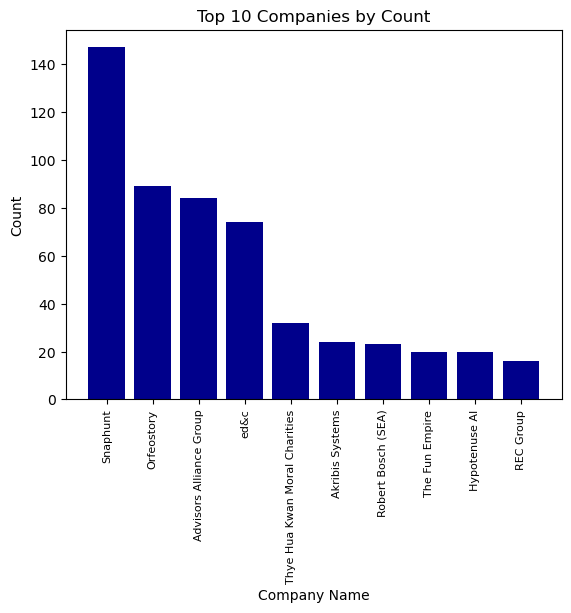

<Figure size 1200x800 with 0 Axes>

In [283]:
plt.bar(top_10_counts.index, top_10_counts.values, color='darkblue')
plt.xlabel('Company Name')
plt.ylabel('Count')
plt.title('Top 10 Companies by Count')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
plt.show()

Unsurprisingly, the most number of job posting made was by SnapHunt, a recruitment agency. Now, let's look at what are the popular roles that companies are looking for.

In [284]:
role_counts = intern_df.groupby('Role')['Role'].count()
top_10_role_counts = role_counts.sort_values(ascending=False).head(10)
top_10_role_counts

Role
Marketing Intern                                                 88
⭐ Assistant Project Manager ⭐                                    87
⭐ Financial Services Intern ⭐                                    81
⭐ Events & Account Servicing Executive Intern (Advertising) ⭐    72
Business Development Intern                                      41
Digital Marketing Intern                                         39
Finance Intern                                                   25
Graphic Design Intern                                            17
Human Resource Intern                                            16
Social Media Intern                                              16
Name: Role, dtype: int64

In this example, we see that there are special characters used by the job poster, such as emoji. Let's remove these to make the results look cleaner.

In [285]:
import re

intern_df['Role'] = intern_df.apply(lambda row: re.sub(r'[^\w\s]', '', row[1]).strip(), axis=1)
intern_df

,Company Name,Role,Commitment Period,Location,Job Type,Date Posted,Website,Work From Home,Country
0,Stena Line,HR Intern Marine,"From Nov 2023, For At Least 6 Months",Jurong East,Intern/TS,27 Jun,stena.com,False,SG
1,Fosun Hive Capital Management (Singapore) Pte....,Finance and Administration Intern,"Immediate Start, For At Least 6 Months",None,Intern/TS,27 Jun,fosunhivecapital.com,False,SG
2,Vipshop Singapore,Data Analyst Intern,"Immediate Start, For At Least 3 Months",None,Intern/TS,27 Jun,vipshop.com,False,SG
3,BSH Home Appliances,Service Marketing Intern,"From Aug 2023, For At Least 5 Months",None,Intern/TS,27 Jun,bshg.com,False,SG
4,BHA,Financial Services Summer Intern,"Flexible Start, For At Least 2 Months",Queenstown,Intern/TS,27 Jun,qiorganization.com,False,SG
...,...,...,...,...,...,...,...,...,...
2635,Vision Alliance Group,Sales Marketing Associate,"Immediate Start, For At Least 6 Months",Newton,Full/Perm,Closed,pruadviser.com.sg,False,SG
2636,Inspire Brands Asia,Content Creation Intern,"Immediate Start, Flexible Duration",Novena,Free/Proj,Closed,inspirebrandsasia.com,False,SG
2637,Count On Me,Accounts Executive Intern,"Immediate Start, For At Least 6 Months",None,Full/Perm,Closed,countonme.biz,False,SG
2638,Elite Asia,Englishchinese Japanese Korean Simultaneous ...,From 08 Jun 2023 - 08 Jun 2023,None,Free/Proj,Closed,eliteasia.co,False,SG


In [286]:
role_counts = intern_df.groupby('Role')['Role'].count()
top_10_role_counts = role_counts.sort_values(ascending=False).head(10)
top_10_role_counts

Role
Assistant Project Manager                                 90
Marketing Intern                                          88
Financial Services Intern                                 88
Events  Account Servicing Executive Intern Advertising    73
Business Development Intern                               42
Digital Marketing Intern                                  39
Finance Intern                                            25
Graphic Design Intern                                     17
Human Resource Intern                                     16
Social Media Intern                                       16
Name: Role, dtype: int64

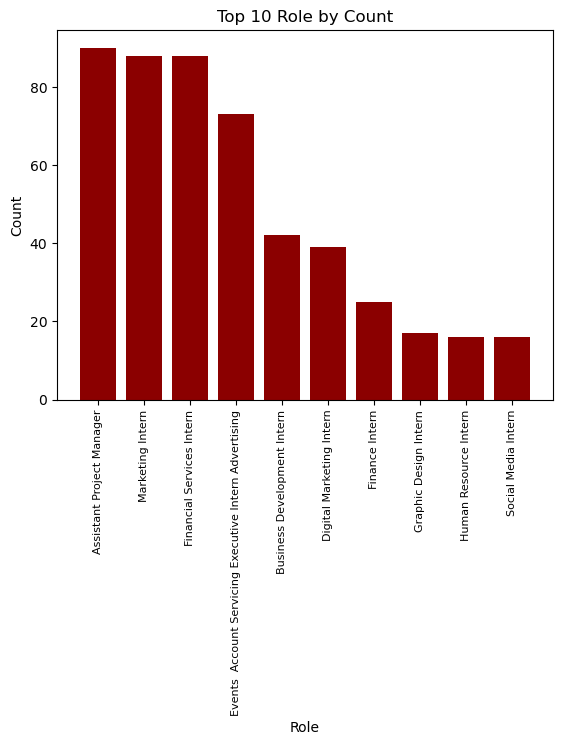

<Figure size 1200x800 with 0 Axes>

In [287]:
plt.bar(top_10_role_counts.index, top_10_role_counts.values, color='darkred')
plt.xlabel('Role')
plt.ylabel('Count')
plt.title('Top 10 Role by Count')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
plt.show()

It seems that roles such as Marketing Intern, Financial Service Intern, Assistant Project Manager and Events Account Servicing Exectutive Intern Advertising are very popular. However, this may be due to the promoted feature of intern.sg, which promotes certain jobs at a fee.

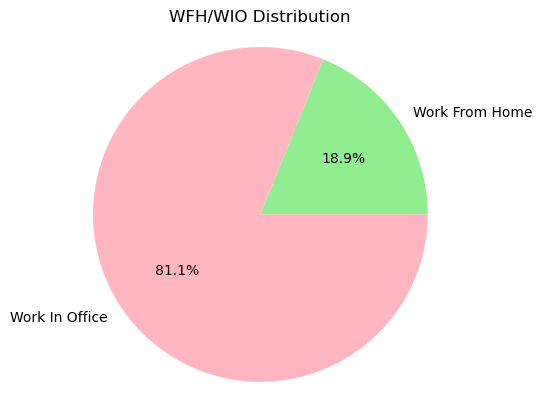

In [288]:
wfh_count = intern_df['Work From Home'].mean()
wio_count = 1 - wfh_count
sizes = [wfh_count, wio_count]
labels = ['Work From Home', 'Work In Office']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen','lightpink'])
plt.axis('equal')
plt.title('WFH/WIO Distribution')
plt.show()


In [292]:
filtered_df = intern_df[intern_df['Date Posted'] != 'Closed']
filtered_df['Date Posted'] = pd.to_datetime(filtered_df['Date Posted'] + ' ' + str(2023), format='%d %b %Y')
posting_over_time = filtered_df.groupby("Date Posted")['Date Posted'].count()

/var/folders/8d/5rvptlnd5j9d3zl2fchct6v00000gn/T/ipykernel_65769/3946368878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date Posted'] = pd.to_datetime(filtered_df['Date Posted'] + ' ' + str(2023), format='%d %b %Y')


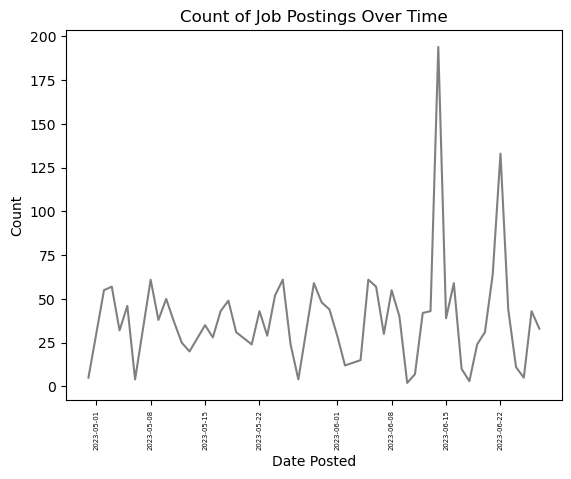

In [293]:
plt.plot(posting_over_time.index, posting_over_time.values, color='grey')
plt.xlabel('Date Posted')
plt.ylabel('Count')
plt.title('Count of Job Postings Over Time')
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.show()


The data look like there are some seasonality to it, with some extreme anomalies. I suspect that the job posting experience a sharp drop when it is a weekend and rises when the work week begins. Let's check if I am correct.

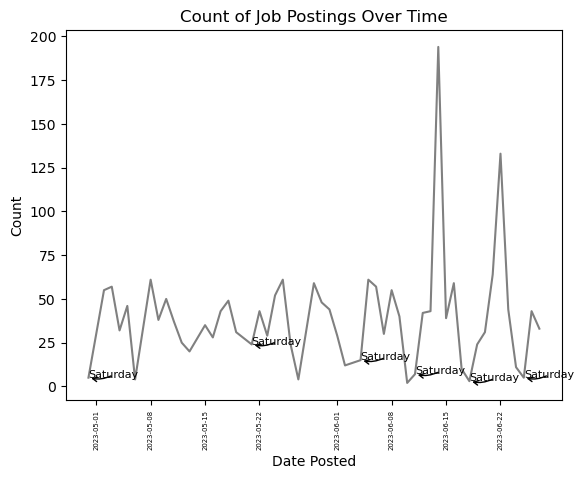

In [291]:
from datetime import datetime

days_of_week = []
for date_string in posting_over_time.index:
    day_of_week = date_string.strftime('%A')
    days_of_week.append(day_of_week)
days_of_week
date_day = list(zip(posting_over_time.index, days_of_week, posting_over_time.values))

plt.plot(posting_over_time.index, posting_over_time.values, color='grey')

for date, day, count in date_day:
    if day == 'Sunday':
        plt.annotate('Saturday',xy=(datetime.strptime(str(date.date()), "%Y-%m-%d"),count), 
            arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'),
            fontsize=8)

plt.xlabel('Date Posted')
plt.ylabel('Count')
plt.title('Count of Job Postings Over Time')
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.show()


As can be seen with the annotation, job posting experience a dip on Saturday.